In [1]:
'''Karan Kumar 14906619'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import scipy.integrate as integrate
from scipy.integrate import quad

In [2]:
#constants from assignment 3 solutions changed for this assignment

M = 4.2E6            # Mass of Sgr A* in M_sun
M_sun = 1.988e33     # Solar mass in g
Ledd = 1.26e38 * M   # Eddington luminosity in erg/s
lightspeed = 2.997e10         # Speed of light in vaccum in cm/s
G = 6.67e-8          # Gravitational constant in erg cm/g^2
rg = G*M*M_sun/lightspeed**2# Gravitational radius in cm
me = 9.1e-28         # Electron mass in g
q = 4.8e-10          # Electron charge in esu
eta = 1e-7           # radiative efficiency
R0 = 10*rg           # beginning radius of the blob in cm
gam = 1000           # we know this from measurements
p = 2                # power law index
nuSSA = 1e12            # frequency in Hz self synchrotron
omega = 2*np.pi*nuSSA # angular frequency
pitch = 10*np.pi/180     # pitch angle in radians
D = 26670*9.461e+17  # Distance to Sgr A* in cm
vr = 0.3*lightspeed
planck = 1e-27 # planck constant in erg*s

lorentz = 10000

In [3]:
def absorption(freq,C,mag):
    '''Evaluate the absorption coefficent for various p indicies 
    include angular dependence
    input: 
    freq- frequnecy
    C: see function C_consant
    mag: magnetic field strength see function mag_density
    variables:
    gammas- evaluate a specific gamma function for different p values
    absorb- the absorption coeifficent
    
    return
    absorb'''
    gamA = gamma((3*p+2)/12)
    gamB = gamma((3*p+22)/12)
    # angle = np.sin(pitch)**(p+2/2)
    abs_const = gamA*gamB*(3*np.sqrt(3)*q**4)/(16*(np.pi**2)*(me**3)*(lightspeed**5))

    absorb = abs_const*C*(mag**2)*(freq**(-3))
    
    return absorb

In [9]:
time_arr = np.logspace(-1,5, 1000) # sec
freq_arr = np.logspace(8,16,1000) #hz
distance = np.logspace(0,22,1000)
z = np.logspace(-2,3,1000)
dz = np.diff(z)
#dz = np.linspace(1,10,1000)*(R0/np.tan(pitch/2))# cm distance to sgrA
def radius(dz):
    R = (R0 + dz *np.tan(pitch/2))
    return R

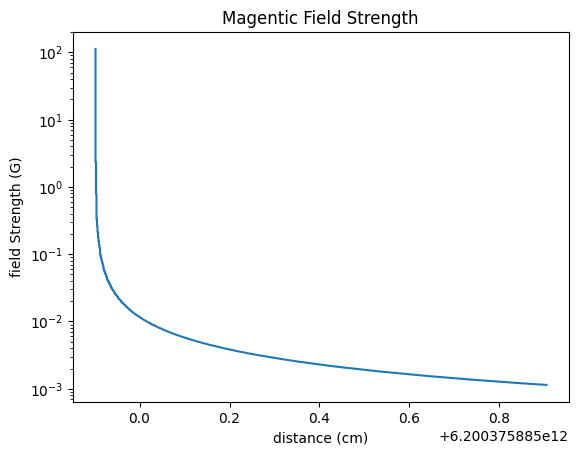

In [10]:
radiusSGRA = radius(dz)# from 10 rg to 1000rg

Rkpc = R0/(10**21)
B0 = ((nuSSA/100e6)/Rkpc**(1/3))
B0 = ((B0)**(3/4))/1e3 # intial

mag_flux = B0*R0*dz[0]#gauss * cm^2 magnetic flux conserved
def magentic_field(Radius, dz):
    '''Calculate the Magnetic field strength of the jet from equipartition
    Define a conserved flux , and return a 1/r dependent field
    input:
    radius- radius of jet in cm
    
    variables:
    B_r - magnetic field Gauss'''
    B_r  = mag_flux/(Radius*dz) #gauss
    return B_r
B_r = magentic_field(radiusSGRA,dz)
plt.plot(radiusSGRA, B_r)
#plt.xscale('log')
plt.yscale("log")
plt.title("Magentic Field Strength")
plt.xlabel("distance (cm)")
plt.ylabel("field Strength (G)")
plt.show()

In [21]:
#redefine frequency array between min and max of characteristic frequncy
lorentz_min = 1

v_min = B_r[-1]*lorentz_min*(4.3e6) #hz
v_max  = B_r[0]*lorentz*(4.3e6) #hz
freq_arr = np.linspace(v_min, v_max, 1000)

A0 = 2*radiusSGRA[0]*dz[0] # area of base of the jet
eta =0.1
mdot = (1e-8)*M_sun/(1e7)
def C_constant(B_r):
    '''Calculate the C constant using the magnetic field strength and maximum energy
    
    input:
    B_r -float of  magnetic field strength in  Gauss
    variables:
    Ub- magnetic field density 
    lorentz - gamma factor
    C_hat: C constant for absorpbtion coefficent
    C : other C constant for power
    return 
    C, C_hat'''
    Ut = (eta*mdot*lightspeed**2)/(2*A0*vr)
    Ub = B_r**2/(8*np.pi)
    Ue = Ub
    C_hat = Ut/np.log(lorentz)

    C = C_hat/(me*lightspeed**2)  # power
    return C, C_hat

In [22]:
def emission_coef(freq, C_const, mag):
    '''Evaluate the emission coefficent for various powers of p 
    input: 
    freq- frequnecy
    C: see function C_consant
    mag: magnetic field strength see function mag_density
    variables:
    gammas- evaluate a specific gamma function for different p values
    emission- the emission coeifficent
    
    return
    emission'''
    gamC = gamma((p/4)+(19/12))
    gamD = gamma((p/4)-(1/12))
    ems_const = (q**2.5*gamC*gamD)/(24*(np.pi**2)*(me**1.5)*(lightspeed**2.5))
    

    emission = (ems_const*C_const)*(mag**1.5)/np.sqrt(2*np.pi*freq)
    return emission

In [29]:
#calculate the C constant
C, C_hat = C_constant(B_r)
# P0 = (10**-18.5)*C_hat[0]*((B_r[0]**3/2))*(nuSSA**(-1/2))/3
#too law
def source(absorb, emission):
    '''Calculate the source function in Cgs units
    Sv = power/(4*pi*absorption_coefficent)
    input: 
    absorb - absorption_coefficent
    emiision - total power
    '''
    return emission/(4*np.pi*absorb)

In [24]:
def Iv(source, tau):
    '''Calculate the intensity in cgs units'''
    Iv = source*(1-np.exp(-tau))
    return Iv
#IvSSA = Iv(Sv,tau)
def flux_spec(freq, Iv,radius):
    '''Calculate the flux spectrum normalize around vssa and inital luminosity'''
    #normalize flux around inital luminosity
    L0 = 10**41
    Fv = Iv*(radius/D)**2
    jansky_cov = 10**-20 # convert to mjansky
    Fv = Fv*jansky_cov
    return Fv
#Fv = flux_spec(freq_arr, IvSSA,radiusSGRA)



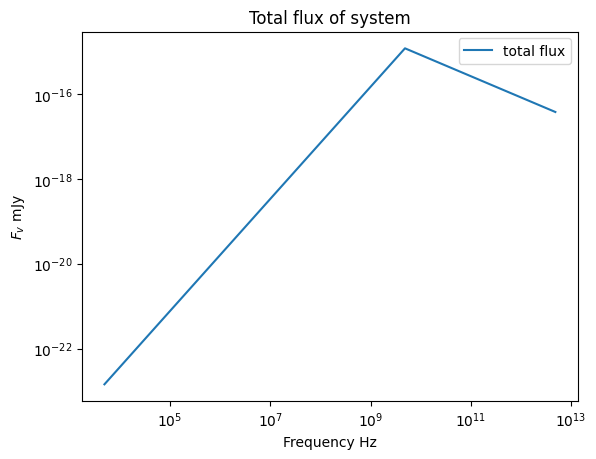

In [25]:
total_flux = []
total_int = []
for i in range(len(radiusSGRA)-1):
    mag_temp =magentic_field(radiusSGRA[i], dz[i])
    C_temp, C_hat_temp = C_constant(mag_temp)
    emission_temp = emission_coef(freq_arr,C_temp, mag_temp)
    absorb_temp = absorption(freq_arr,C_hat_temp, mag_temp)
    source_temp = source(absorb_temp,emission_temp)
    tau_temp = absorb_temp*radiusSGRA[i]
    Iv_temp = Iv(source_temp,tau_temp)
    total_int.append(Iv_temp)
    Fv_temp = flux_spec(freq_arr, Iv_temp, radiusSGRA[i])
    total_flux.append(Fv_temp)
    #plt.plot(freq_arr,Fv_temp)

#sum all the slices
total_spectrum = [sum(x) for x in zip(*total_flux)]

plt.title("Total flux of system")
plt.xscale('log')
plt.yscale("log")
plt.ylabel("$F_v$ mJy")
plt.xlabel("Frequency Hz")
plt.plot(freq_arr, total_spectrum, label= "total flux")
plt.legend()
plt.show()


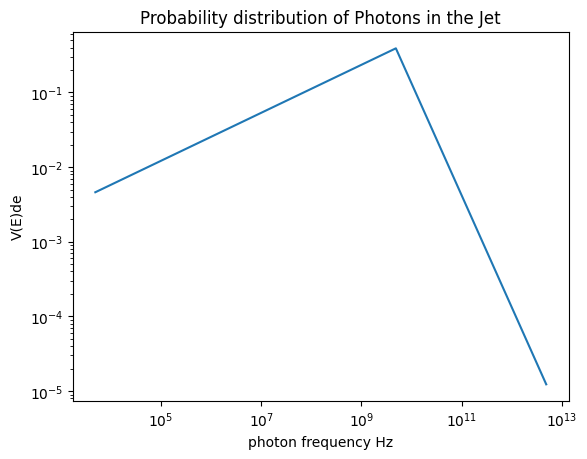

In [26]:
#everything for assignment 5 here
total_int_final = [sum(x) for x in zip(*total_int)]

electron_energy = np.linspace(me*lightspeed**2, lorentz*me*lightspeed**2, num=len(total_int_final))
photon_energy = planck*freq_arr
#make a distribution copied from the distribution demo
def freq_distro(intensity, photon_energy):
    '''Create a frequency distribution as function of energy
    v(e)de = intensity/hv
    input:
    Intensity-array of Intnesity spectrum cgs
    photon_ energy - array of energy cgs
    Variables:

    number_of_photons - float array of total number of photons in the jet
    pdf- probability density function for photon
    ve_distro - number of 
    return- ve_distro, pdf'''

    number_of_photons= (intensity)/(4*np.pi*photon_energy)
    pdf = number_of_photons/np.sum(number_of_photons)
    cdf = np.cumsum(pdf)
    u = np.random.uniform(0, 1, size=len(photon_energy))
    ve_distro = np.interp(u, cdf, freq_arr)
    return ve_distro, pdf
ve_distro, pdfVE = freq_distro(total_int_final, photon_energy)
plt.plot(freq_arr, pdfVE)
plt.xscale('log')
plt.yscale("log")
plt.ylabel("V(E)de")
plt.title("Probability distribution of Photons in the Jet")
plt.xlabel("photon frequency Hz")
plt.show()

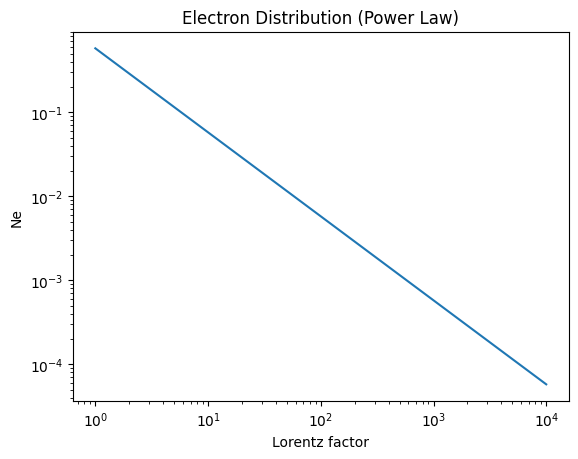

In [27]:
#create an electron distriubtion 
def electron_distro(electron_energy, C):
    '''ne = C E^-p dE
    calculate the electron energy distribution
    input:
    electon_energy- array of energies
    C - from energy density see C_const funciton
    
    variables:
    number_of_electrons - similar to freq distro calculate the number of electrons
    from power law distro
    pdf- probability density function for number of electrons
    return
    ne, pdf'''
    number_of_electrons = C*(electron_energy**(-p+1)) #make a pdf of the electron distribution
    pdf = number_of_electrons/np.sum(number_of_electrons) # normalize the pdf
    cdf = np.cumsum(pdf) # make a cdf

    u = np.random.uniform(0, 1, size=len(electron_energy))
    ne = np.interp(u, cdf, electron_energy)
    return ne, pdf

#evaulate at the base of the jet
ne, pdfNE = electron_distro(electron_energy, C)
plt.plot(electron_energy/(me*lightspeed**2), pdfNE) # plot as funcion of lorentz factor
plt.xscale('log')
plt.yscale("log")
#plt.hist(ne, bins=10, density=True, alpha=0.6, color='b')
plt.xlabel("Lorentz factor")
plt.ylabel("Ne")
plt.title("Electron Distribution (Power Law)")
plt.show()

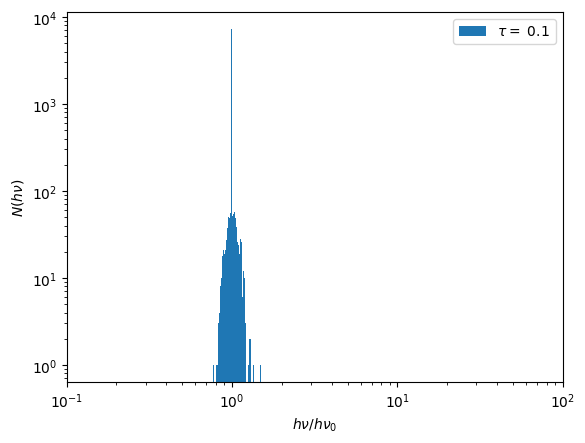

Fraction of escaping photons: 8.616e-01

Compton y parameter: 2.537e-03



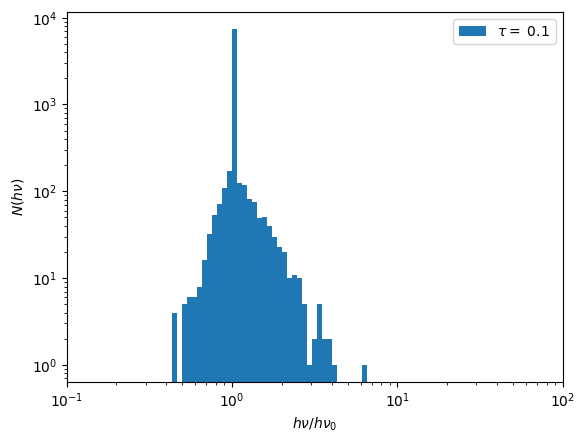

Fraction of escaping photons: 8.553e-01

Compton y parameter: 3.082e-02



C:\Users\KNL\AppData\Local\Temp\ipykernel_2420\3969744291.py:184: RuntimeWarning: overflow encountered in exp
  return x**2/(np.exp(x)-1)/norm


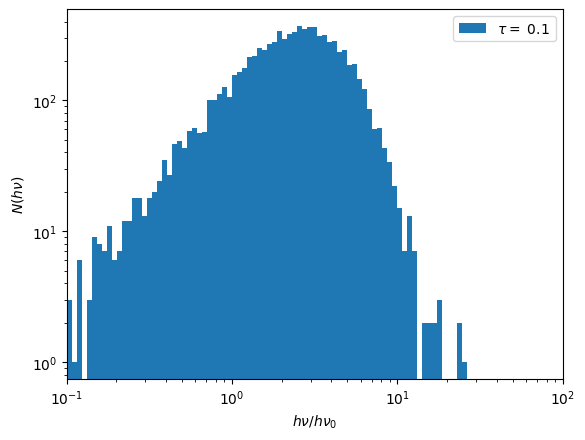

Fraction of escaping photons: 8.579e-01

Compton y parameter: 3.078e-02



In [28]:
c_light=lightspeed            
m_electron=9.10938356e-28  
sigma_t=6.65e-25           
figure_counter=0           

#copy the MC tutorial
def compton_y(pre,post):
    y = np.mean((post-pre)/pre)
    return(y)

def random_direction(number=None):
    if number is None:
        number=1
    phi=np.random.rand(number)*2.*np.pi
    cos_theta=2.*np.random.rand(number)-np.ones(number)
    sin_theta= np.sqrt(1-cos_theta**2)
    return((np.array([sin_theta*np.cos(phi),sin_theta*np.sin(phi),cos_theta])).transpose())

def f_of_hnu_mono(mc_parms,number=None):
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

def photon_origin(number=None):
    if number is None:
        number=1
    return(np.zeros([number,3]))

def draw_seed_photons(mc_parms,number=None):
    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

def tau_of_scatter():
    return(-np.log(np.random.rand()))

def distance_of_scatter(mc_parms):
    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density    
    return(distance)

def scatter_location(x_old,p_photon,mc_parms):
    distance = distance_of_scatter(mc_parms)
    photon_direction=p_photon[1:]/p_photon[0]
    x_new = x_old + distance*photon_direction
    return(x_new)

def f_of_v_mono(mc_parms):
    return(mc_parms['velocity'])

def draw_electron_velocity(mc_parms,p_photon):
    v=mc_parms['v_dist'](mc_parms)
    n=draw_electron_direction(v,p_photon)
    return(v*n)

def draw_electron_direction(v,p_photon):
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=mu_of_p_electron(v/c_light,np.random.rand())
    sint=np.sqrt(1 - cost**2)
    
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    
    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    return(n_new/np.sqrt(np.sum(n_new**2)))

def mu_of_p_electron(beta,p):
    mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
    return(mu)

def lorentz_transform(p,v):
    beta=np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

def cos_theta_thomson(p):
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))

def thomson_scatter(p_photon):
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

def inverse_compton_scatter(p_photon,mc_parms):
    velocity=draw_electron_velocity(mc_parms,p_photon)
    p_photon_prime=lorentz_transform(p_photon,velocity)
    p_out_prime=thomson_scatter(p_photon_prime)
    return(lorentz_transform(p_out_prime,-velocity))

def monte_carlo(mc_parms):
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        hnu_seed[i]=p_photon[0]*c_light
        scattered=True
        while (scattered):
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0
        hnu_scattered[i]=p_photon[0]*c_light
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

def plot_mc(mc_parms,bins=None,xlims=None,filename=None):
    global figure_counter
    if (xlims is None):
        xlims=[0.1,100]    
    if (bins is None):
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=100)
    if (filename is None):
        filename='inverse_compton_MC_{0:d}.pdf'.format(figure_counter)
    hnu_scattered,hnu_seeds=np.array(monte_carlo(mc_parms))/mc_parms['kt_seeds'] 
    fig=plt.figure()
    plt.hist(hnu_scattered,bins=bins,log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']))
    plt.xscale('log')
    plt.xlim(xlims[0],xlims[1])
    plt.xlabel(r'$h\nu/h\nu_{0}$')
    plt.ylabel(r'$N(h\nu)$')
    plt.legend()
    #fig.savefig(filename)
    figure_counter+=1
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)

mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'velocity':3e9,'tau':0.1,'v_dist':f_of_v_mono,'hnu_dist':f_of_hnu_mono}

hnu_scattered,hnu_seeds=plot_mc(mc_parms,bins=100)

def f_of_v_maxwell(mc_parms):
    v=3e10
    while v >= c_light:
        v=np.sqrt(mc_parms['kt_electron']/(m_electron))*np.sqrt(np.sum((np.random.normal(0,1,3))**2))
    return(v)

mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'velocity':3e9,'tau':0.1,'kt_electron':3.2e-8,'v_dist':f_of_v_maxwell,'hnu_dist':f_of_hnu_mono}
mc_parms['velocity']=np.sqrt(mc_parms['kt_electron']/(m_electron))
hnu_scattered,hnu_seeds=plot_mc(mc_parms)

def f_planck(x):
    norm=2.4041138063192817
    return x**2/(np.exp(x)-1)/norm

def p_planck(hnu=None):
    if (hnu is None):
        number=1000
        hnu=np.append(np.linspace(0,1-1./number,number),np.logspace(0,4,number))

    p=np.zeros(2*number)
    for i in range(1,2*number):
        p[i]=((quad(f_planck,0,hnu[i]))[0])
    return (p,hnu)

def hnu_of_p_planck(number=None,pdf=None,hnu=None):
    if number is None:
        number=1
    if (pdf is None):
        pdf,hnu=p_planck()

    e_phot=np.interp(np.random.rand(number),pdf,hnu)
    return(e_phot,pdf,hnu)

def f_of_hnu_planck(mc_parms,number=None,pdf=None,energies=None):
    if number is None:
        number=1
    if (pdf is None):
        e,pdf,energies=hnu_of_p_planck(number=number)
    else:
        e,pdf,energies=hnu_of_p_planckl(number=number,pdf=pdf,hnu=energies)        
    e*=mc_parms['kt_seeds']    
    return(e)

mc_parms={'n_photons':10000,
          'kt_seeds':1.6e-9,
          'H':1e7,
          'tau':0.1,
          'kt_electron':3.2e-8,
          'v_dist':f_of_v_maxwell,
          'hnu_dist':f_of_hnu_planck}

hnu_scattered,hnu_seeds=plot_mc(mc_parms)

C:\Users\KNL\AppData\Local\Temp\ipykernel_2420\3969744291.py:184: RuntimeWarning: overflow encountered in exp
  return x**2/(np.exp(x)-1)/norm


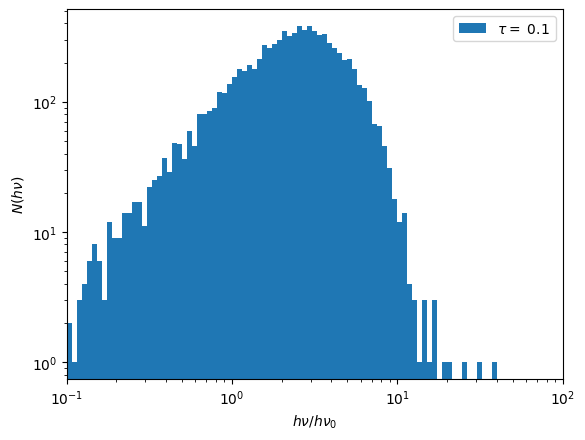

Fraction of escaping photons: 8.592e-01

Compton y parameter: 3.130e-02



In [34]:

#modify the monte carlo sim so that the inputs come from my spectrum
def f_of_v_maxwell(mc_parms):
    v=3e10
    while v >= c_light:
        v=np.sqrt(mc_parms['kt_electron']/(m_electron))*np.sqrt(np.sum((np.random.normal(0,1,3))**2))
    return(v)

#modify the hnu_planck fuction using the distribution calculated from my Jet
#pdf = pdfVE
def f_of_photons(mc_parms,number=None,pdf=None,energies=None):
    if number is None:
        number=1
    if (pdf is None):
        pdf = pdfVE
        e,temp,energies=hnu_of_p_planck(number=number)
    else:
        e,pdf,energies=hnu_of_p_planckl(number=number,pdf=pdfVE,hnu=energies)        
    e*=mc_parms['kt_seeds']    
    return(e)
my_mc_parms={'n_photons':10000,
          'kt_seeds':1.6e-9,
          'H':1e7,
          'tau':0.1,
          'kt_electron':3.2e-8,
          'v_dist':f_of_v_maxwell,
          'hnu_dist':f_of_photons}

hnu_scattered,hnu_seeds=plot_mc(my_mc_parms)